In [119]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

train = pd.read_csv("../1st week/dataset/housing_train.csv")
test = pd.read_csv("../1st week/dataset/housing_test.csv")


In [120]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


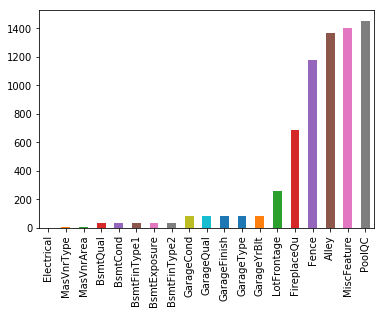

In [121]:
missing = train.isnull().sum()
missing = missing[missing >0]
missing.sort_values(inplace=True)
missing.plot.bar()

### 19 attributes have missing values, 5 over 50% of all data

In [122]:
train = train.drop(columns=['FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC'])

numerical = [f for f in train.columns if train.dtypes[f] != 'object']
numerical.remove('SalePrice')
numerical.remove('Id')
categorical = [f for f in train.columns if train.dtypes[f] == 'object']

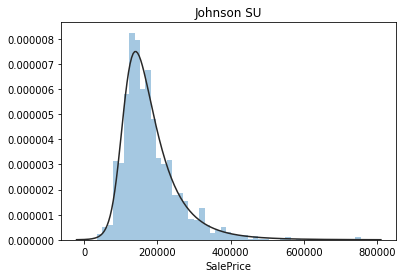

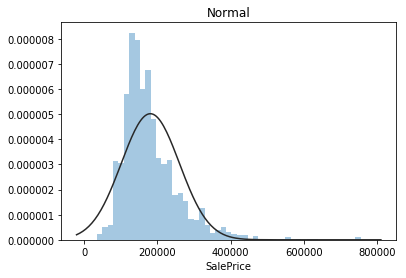

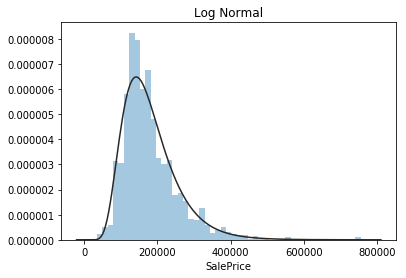

In [123]:
import scipy.stats as st
y = train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

In [124]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[numerical])
normal = normal.apply(test_normality)
print(not normal.any())

False


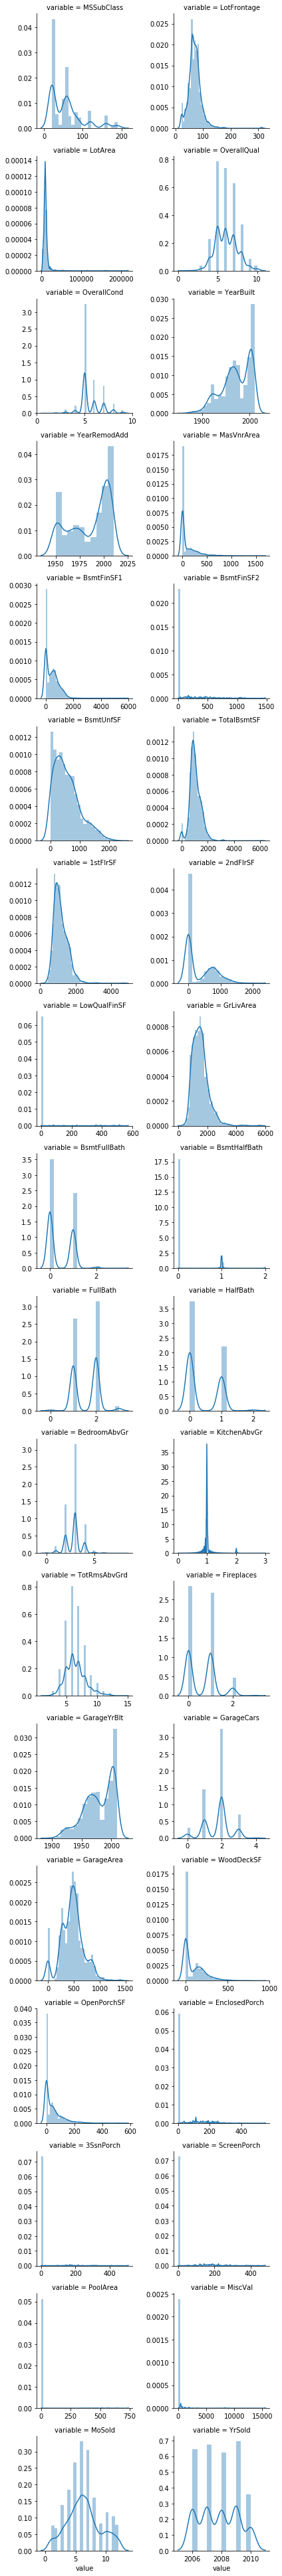

In [125]:
f = pd.melt(train, value_vars=numerical)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

### Some independent variables look like good candidates for log transformation: TotalBsmtSF, KitchenAbvGr, LotFrontage, LotArea and others

## categorical data

In [126]:
for c in categorical: 
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')

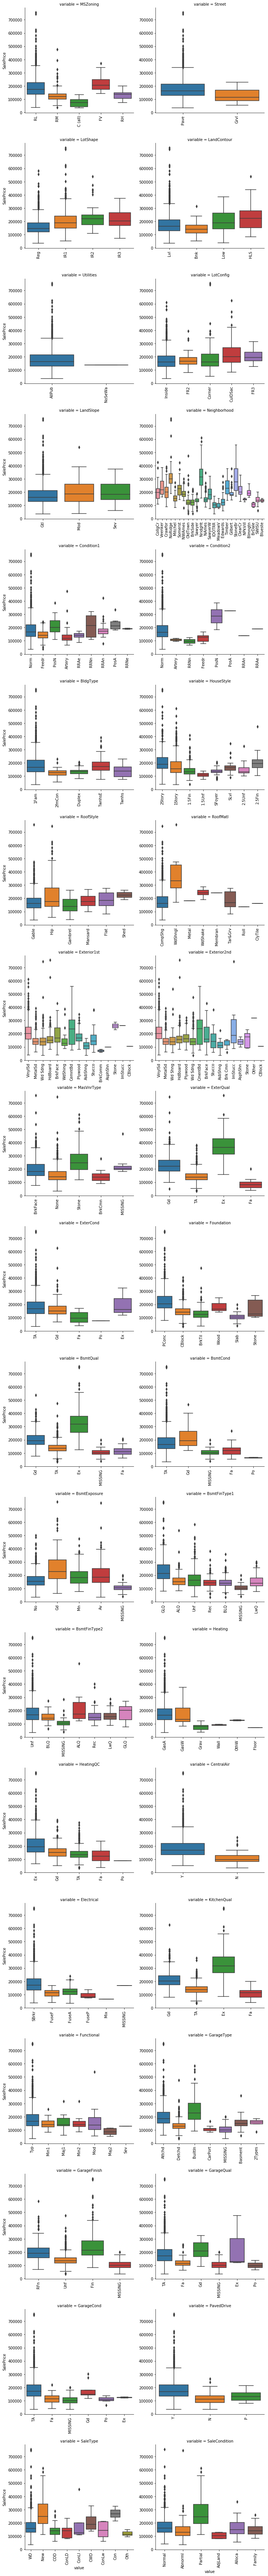

In [127]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train, id_vars=['SalePrice'], value_vars=categorical)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")

In [128]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o

cate_encoded = []
for q in categorical:  
    encode(train, q)
    cate_encoded.append(q+'_E')
print(cate_encoded)

['MSZoning_E', 'Street_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'SaleType_E', 'SaleCondition_E']


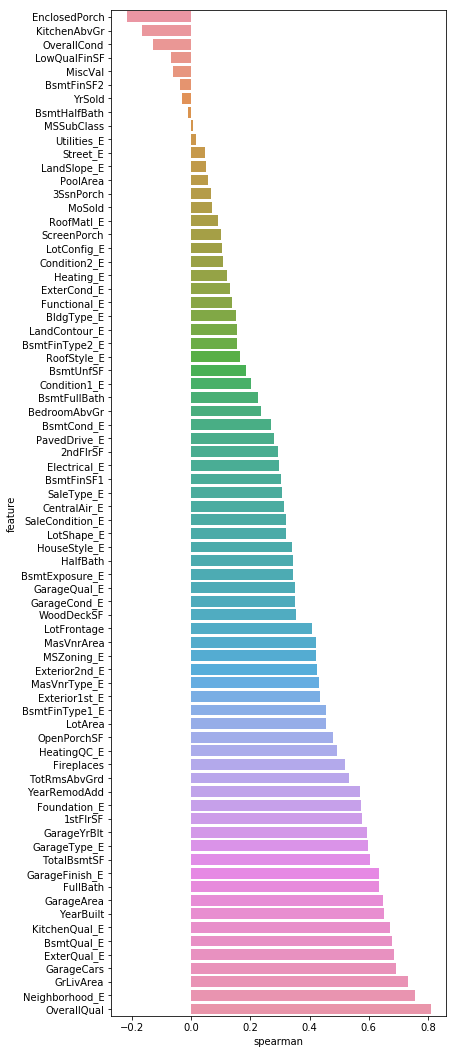

In [129]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = numerical + cate_encoded
spearman(train, features)

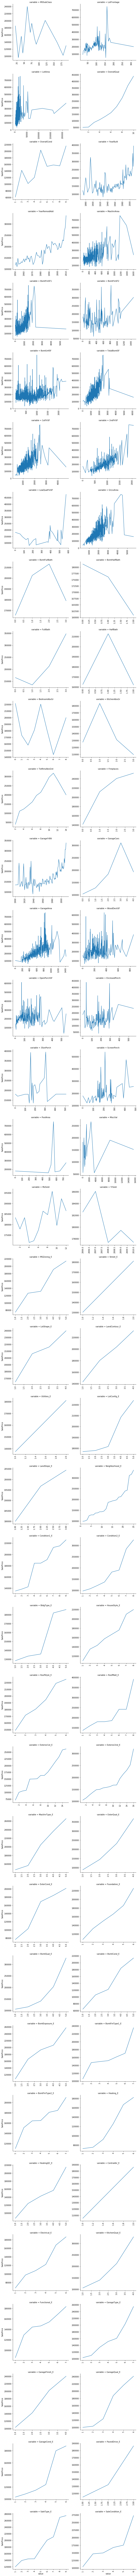

In [130]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(train, id_vars=['SalePrice'], value_vars=numerical+cate_encoded)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(pairplot, "value", "SalePrice")

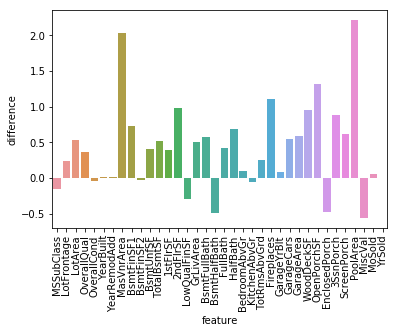

In [131]:
features = numerical

standard = train[train['SalePrice'] < 200000]
pricey = train[train['SalePrice'] >= 200000]

diff = pd.DataFrame()
diff['feature'] = features
diff['difference'] = [(pricey[f].fillna(0.).mean() - standard[f].fillna(0.).mean())/(standard[f].fillna(0.).mean())
                      for f in features]

sns.barplot(data=diff, x='feature', y='difference')
x=plt.xticks(rotation=90)

In [132]:
def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

def log_transform(feature):
    train[feature] = np.log1p(train[feature].values)

def quadratic(feature):
    train[feature+'2'] = train[feature]**2

In [133]:
log_transform('GrLivArea')
log_transform('1stFlrSF')
log_transform('2ndFlrSF')
log_transform('TotalBsmtSF')
log_transform('LotArea')
log_transform('LotFrontage')
log_transform('KitchenAbvGr')
log_transform('GarageArea')

train['HasBasement'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasGarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train['Has2ndFloor'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasMasVnr'] = train['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
train['HasWoodDeck'] = train['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPorch'] = train['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train['IsNew'] = train['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
            'HasPorch', 'HasPool', 'IsNew']

In [134]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train, train["OverallQual"]):
    train_set = train.loc[train_index]
    test_set = train.loc[test_index]

In [135]:
features = numerical + cate_encoded + boolean
X = train_set[features].fillna(0.).values
Y = train_set['SalePrice'].values

In [136]:
from sklearn.metrics import mean_squared_error

lin_reg = linear_model.LinearRegression()
lin_reg.fit(X, np.log(Y))

Ypred_lin_reg = np.exp(lin_reg.predict(X))
error(Y, Ypred_lin_reg)

0.10684656767003689

In [137]:
lasso = linear_model.LassoLarsCV(max_iter=10000)
lasso.fit(X, np.log(Y))

Ypred_lasso = np.exp(lasso.predict(X))
error(Y, Ypred_lasso)

0.11856356541598477

In [138]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X, np.log(Y))

Ypred_tree = np.exp(tree_reg.predict(X))
error(Y, Ypred_tree)


2.4066422594216263e-05

## Fine-tune your model

In [139]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, X, Y,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [140]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [38633.01715065 36510.55148904 27918.99795134 37624.23233473
 40805.26688855 34035.4396371  40000.17109162 29807.63927953
 44569.80707534 29327.03256618]
Mean: 35923.21554640911
Standard deviation: 5237.767496068582


In [141]:
lin_scores = cross_val_score(lin_reg, X, Y,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 21794.44790144  29769.14905046  27467.26450943 246094.27349953
  24509.32886378  23179.98787971  32306.29092459  28442.03874296
  70889.94396857  30589.99725406]
Mean: 53504.272259452344
Standard deviation: 65576.4957067392


In [142]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X, np.log(Y))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [143]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, X, Y,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [25693.3701373  33246.82709019 22576.41216829 25119.88295777
 28087.95660985 24641.69258264 29772.06229248 26164.94919721
 41486.00087329 24114.11476088]
Mean: 28090.32686699047
Standard deviation: 5340.827936677696


In [144]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X, Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [145]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [146]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

38777.30204542335 {'max_features': 2, 'n_estimators': 3}
33268.74532488882 {'max_features': 2, 'n_estimators': 10}
31068.804829566045 {'max_features': 2, 'n_estimators': 30}
36684.77285357636 {'max_features': 4, 'n_estimators': 3}
30967.007693325977 {'max_features': 4, 'n_estimators': 10}
29593.401179216144 {'max_features': 4, 'n_estimators': 30}
37113.53591475994 {'max_features': 6, 'n_estimators': 3}
30603.119919040717 {'max_features': 6, 'n_estimators': 10}
29386.09976522065 {'max_features': 6, 'n_estimators': 30}
34944.56156532609 {'max_features': 8, 'n_estimators': 3}
29520.848131091134 {'max_features': 8, 'n_estimators': 10}
28708.69661802682 {'max_features': 8, 'n_estimators': 30}
36992.628285799634 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
31672.00338053212 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
37323.849965900044 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
31617.329751999452 {'bootstrap': False, 'max_features': 3, 'n_estimat

In [147]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=30, high=200),
        'max_features': randint(low=3, high=10),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X, Y)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a20342fd0>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a203429e8>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [148]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

27280.56671811174 {'max_features': 9, 'n_estimators': 122}
27242.032035983782 {'max_features': 9, 'n_estimators': 136}
28329.979105477716 {'max_features': 7, 'n_estimators': 50}
27185.041599203054 {'max_features': 9, 'n_estimators': 151}
28795.13869339181 {'max_features': 5, 'n_estimators': 104}
28601.255575008745 {'max_features': 5, 'n_estimators': 117}
27851.36848282503 {'max_features': 7, 'n_estimators': 129}
28529.670456964475 {'max_features': 5, 'n_estimators': 179}
28674.44709038062 {'max_features': 7, 'n_estimators': 31}
28195.081826906207 {'max_features': 6, 'n_estimators': 187}


In [149]:
final_model = grid_search.best_estimator_

X_test = test_set[features].fillna(0.).values
y_test = test_set['SalePrice'].values

final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [150]:
final_rmse

39745.95086642357

In [152]:
Ypred_final = np.exp(final_model.predict(X_test))
Ypred_final

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


inf

# test

In [153]:
test = test.drop(columns=['FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC'])
numerical_test = [f for f in test.columns if test.dtypes[f] != 'object']
numerical_test.remove('SalePrice')
numerical_test.remove('Id')
categorical_test = [f for f in test.columns if test.dtypes[f] == 'object']

cate_encoded_test = []
for q in categorical_test:  
    encode(test, q)
    cate_encoded_test.append(q+'_E')

features = numerical_test + cate_encoded_test + boolean    
def log_transform(feature):
    test[feature] = np.log1p(test[feature].values)

log_transform('GrLivArea')
log_transform('1stFlrSF')
log_transform('2ndFlrSF')
log_transform('TotalBsmtSF')
log_transform('LotArea')
log_transform('LotFrontage')
log_transform('KitchenAbvGr')
log_transform('GarageArea')

test['HasBasement'] = test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
test['HasGarage'] = test['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
test['Has2ndFloor'] = test['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
test['HasMasVnr'] = test['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
test['HasWoodDeck'] = test['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
test['HasPorch'] = test['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
test['HasPool'] = test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
test['IsNew'] = test['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
            'HasPorch', 'HasPool', 'IsNew']




X_test = test[features].fillna(0.).values
test_predictions = final_model.predict(X_test)

KeyError: "['MSZoning_E' 'Street_E' 'LotShape_E' 'LandContour_E' 'Utilities_E'\n 'LotConfig_E' 'LandSlope_E' 'Neighborhood_E' 'Condition1_E'\n 'Condition2_E' 'BldgType_E' 'HouseStyle_E' 'RoofStyle_E' 'RoofMatl_E'\n 'Exterior1st_E' 'Exterior2nd_E' 'MasVnrType_E' 'ExterQual_E'\n 'ExterCond_E' 'Foundation_E' 'BsmtQual_E' 'BsmtCond_E' 'BsmtExposure_E'\n 'BsmtFinType1_E' 'BsmtFinType2_E' 'Heating_E' 'HeatingQC_E'\n 'CentralAir_E' 'Electrical_E' 'KitchenQual_E' 'Functional_E'\n 'GarageType_E' 'GarageFinish_E' 'GarageQual_E' 'GarageCond_E'\n 'PavedDrive_E' 'SaleType_E' 'SaleCondition_E' 'HasBasement' 'HasGarage'\n 'Has2ndFloor' 'HasMasVnr' 'HasWoodDeck' 'HasPorch' 'HasPool' 'IsNew'] not in index"